In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib


nb-bobabel
lsst_distrib          22.0.1-3-g7ae64ea+3baa4596b0 	current w_2021_33 setup


In [2]:
%matplotlib inline

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import vstack
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import ZScaleInterval
from astropy.io import ascii

In [3]:
import lsst.daf.persistence as dafPersist
import lsst.geom as geom
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import lsst.afw.display as afwDisplay
import lsst.pipe.base as pipeBase
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig

In [4]:
# Set up some plotting defaults:

params = {
   'axes.labelsize': 28,
   'font.size': 24,
   'legend.fontsize': 14,
   'xtick.major.width': 3,
   'xtick.minor.width': 2,
   'xtick.major.size': 12,
   'xtick.minor.size': 6,
   'xtick.direction': 'in',
   'xtick.top': True,
   'lines.linewidth':3,
   'axes.linewidth':3,
   'axes.labelweight':3,
   'axes.titleweight':3,
   'ytick.major.width':3,
   'ytick.minor.width':2,
   'ytick.major.size': 12,
   'ytick.minor.size': 6,
   'ytick.direction': 'in',
   'ytick.right': True,
   'figure.figsize': [9, 8]
   }

plt.rcParams.update(params)

Replace the gen2 Butler with gen3. As of 9/13, I don't have authorization at NCSA, but I learned how to set up the Butler, thanks to Jim Bosch. Re-read the README.md in /repo/main/

In [5]:
depth = 'DEEP' #'WIDE' -- which survey depth (DEEP, WIDE, ULTRA-DEEP) do you want?
butler = dafPersist.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

<ipython-input-5-c0beaf82bdf7>:2: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dafPersist.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))
<ipython-input-5-c0beaf82bdf7>:2: FutureWarning: Gen2 Butler has been deprecated (HscMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = dafPersist.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))


In [6]:
infiles = glob.glob('/datasets/hsc/repo/rerun/DM-13666/%s/deepCoadd-results/HSC-I/*/*/calexp-*.fits'%(depth))
# How many tract/patch files are in this repo?
print(len(infiles))

1303


In [7]:
def getPatchCenter(skymap, tract, patch):
    # Find the center of the patch BBox in pixel coordinates and convert with tract WCS
    patch = list(map(int, patch.split(',')))
    wcs = skymap.generateTract(tract).getWcs()
    bbox = skymap.generateTract(tract).getPatchInfo(patch).getInnerBBox()
    sky = wcs.pixelToSky(np.mean((bbox.getBeginX(), bbox.getEndX())), 
                         np.mean((bbox.getBeginY(), bbox.getEndY())))
    return sky[0].asDegrees(), sky[1].asDegrees()

tract_array = []
patch_array = []

# Each line of "infiles" looks like this (infile[0]):
# '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-I/17130/8,8/calexp-HSC-I-17130-8,8.fits'

# Split on the '/', then parse the resulting array. Here's the result of infiles[0].split('/'):
#['',
# 'datasets',
# 'hsc',
# 'repo',
# 'rerun',
# 'DM-13666',
# 'DEEP',
# 'deepCoadd-results',
# 'HSC-I',
# '17130',
# '8,8',
# 'calexp-HSC-I-17130-8,8.fits']

# So the tract number is third from the end, and patch is second from the end.

for ii in range(0, len(infiles)):
    parts = infiles[ii].split('/')
    tract_array.append(int(parts[-3]))
    patch_array.append(parts[-2])

print('Found %i patches'%(len(patch_array)))
    
skymap = butler.get('deepCoadd_skyMap')
    
ra_center_array = np.tile(0., len(patch_array))
dec_center_array = np.tile(0., len(patch_array))
for ii, (tract, patch) in enumerate(zip(tract_array, patch_array)):
    ra_center_array[ii], dec_center_array[ii] = getPatchCenter(skymap, tract, patch)
    
# Assemble in pandas data frame    
data = {'tract': tract_array,
        'patch': patch_array, 
        'ra_center': ra_center_array, 
        'dec_center': dec_center_array}
df_tract_patch = pd.DataFrame(data=data)

Found 1303 patches


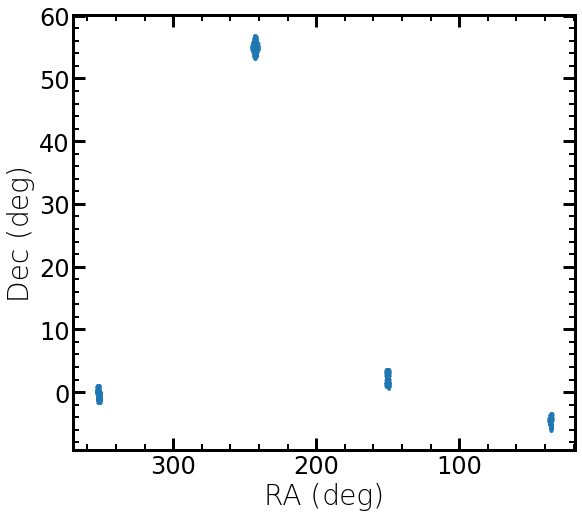

In [8]:
# Plot RA, Dec of patch centers:

fig=plt.figure()
plt.scatter(df_tract_patch['ra_center'], df_tract_patch['dec_center'], marker='.', s=5)
# From looking it up on NED, KKR 25 is in the "ELAIS-N1" field.
# Uncomment the xlim, ylim below to zoom in on that region.
#plt.xlim(238., 246.)
#plt.ylim(52., 58.)
plt.gca().invert_xaxis() # flip the x-axis so the plot is "sky-right"
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.show()

In [9]:
# Create "SkyCoord" objects for the central coordinate of KKR25 (or CetusIII, VirgoI?), and the patch centers of HSC:
kkr25_pos = SkyCoord(243.448333*u.degree, 54.37111*u.degree, frame='icrs') # KKR25
#cosmos_patch_cen = SkyCoord(180.04*u.degree, 0.68*u.degree, frame='icrs') # VirgoI
hsc_patch_cen = SkyCoord(df_tract_patch['ra_center'].values*u.degree, df_tract_patch['dec_center'].values*u.degree, frame='icrs')

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_patches = hsc_patch_cen.separation(kkr25_pos)

# Pick patches within 'size_select' deg of KKR25:
size_select = 0.25 # in degrees
selection_patch = (sep_patches.degree < size_select) 
print('Number of patches selected: ',np.sum(selection_patch))

# Add the separation (in arcminutes) to the dataframe:
df_tract_patch['sep_from_kkr25'] = sep_patches.arcmin

# Extract just the selected (nearby) patches:
df_selected = df_tract_patch[selection_patch]

Number of patches selected:  8


In [10]:
# Print some info about the selected patches:
df_selected

tract patch   ra_center  dec_center  sep_from_kkr25
3    17130   0,4  243.779176   54.290800       12.537841
6    17130   1,5  243.463800   54.480400        6.579589
15   17130   0,5  243.784999   54.477419       13.371343
62   17130   2,4  243.139628   54.295875       11.705172
73   17130   1,4  243.459432   54.293760        4.657199
76   17130   2,5  243.142540   54.482530       12.594279
733  17131   8,4  243.720664   54.290798       10.677045
742  17131   8,5  243.714840   54.477417       11.279527

In [11]:

dataref14 = {'tract':17130, 'patch':'1,4', 'filter':'HSC-G'}

# Note that we can extract the information directly from the dataframe we made above rather
#   than explicity typing the values, like so:
#dataref14 = {'tract':df_selected.iloc[4]['tract'],'patch':df_selected.iloc[4]['patch'],
#             'filter':'HSC-G'}

In [12]:
butler.datasetExists('deepCoadd_forced_src', dataId=dataref14)


True

In [13]:
# Full patch image
image14 = butler.get('deepCoadd_calexp', dataId=dataref14)
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0_14 = image14.getXY0()

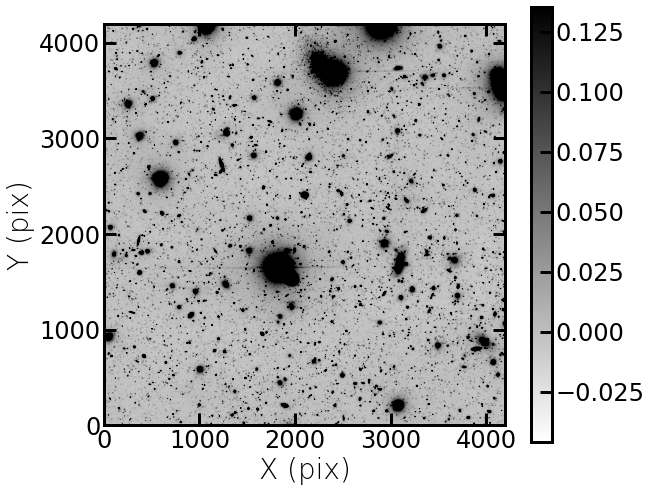

In [14]:
zscale = ZScaleInterval()

plt.rcParams.update({'figure.figsize' : (9, 8)})

vmin14, vmax14 = zscale.get_limits(image14.image.array)
# Get the dimensions of the image so we can set plot limits
imsize14 = image14.getDimensions()
plt.imshow(image14.image.array, vmin=vmin14, vmax=vmax14, cmap='binary')

# Set the plot range to the dimensions:
plt.xlim(0,imsize14[0])
plt.ylim(0,imsize14[1])
plt.colorbar()
plt.xlabel('X (pix)')
plt.ylabel('Y (pix)')

plt.show()

In [15]:
# A useful function we'll use in a little bit.
#   Calculate the number of pixels in a given N-arcmin area.
def arcmin2pix(narcmin):
    arcsecPerPix = 0.168  # HSC pixels are 0.168"/pixel
    arcminPerPix = arcsecPerPix / 60.0
    npix = narcmin/arcminPerPix
    return int(np.rint(npix))

In [16]:
def cutoutImage(raDec, size_arcmin, dataref):
    '''
    Function to extract an image cutout.
    Inputs:
      raDec: an afwGeom.SpherePoint object with desired RA, Dec center 
      size_arcmin: desired image size (in arcminutes)
      filter: desired filter of extracted image (string)
    '''
    # Start with a center position and make a bbox centered there, and expand it to include data from neighboring patches:
    skyMap =  butler.get("deepCoadd_skyMap", immediate=True, dataId=dataref)
    tmp_calexp = butler.get("deepCoadd_calexp", immediate=True, dataId=dataref)
    expWcs = tmp_calexp.getWcs()

    size_pixels = arcmin2pix(size_arcmin)
    print('npixels: ',size_pixels)
    cutoutSize = geom.ExtentI(size_pixels, size_pixels) # size of cutout in pixels
    print('cutoutSize: ',cutoutSize)
    print(expWcs.skyToPixel(raDec))
    xy = geom.Point2I(expWcs.skyToPixel(raDec)) # central XY coordinate of our star's RA, Dec position

    # Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)
    bbox = geom.Box2D(bbox)

    tractInfo = skyMap.findTract(raDec)
    skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in bbox.getCorners()]
    patchList = tractInfo.findPatchList(skyCorners)

    # compute coadd bbox
    coaddWcs = tractInfo.getWcs()
    coaddBBox = geom.Box2D()
    for skyPos in skyCorners:
        coaddBBox.include(coaddWcs.skyToPixel(skyPos))
    coaddBBox = geom.Box2I(coaddBBox)

    # assemble coadd exposure from subregions of patches
    coaddExposure = afwImage.ExposureF(coaddBBox, coaddWcs)
    coaddExposure.maskedImage.set(np.nan, afwImage.Mask.getPlaneBitMask("NO_DATA"), np.nan)
    nPatchesFound = 0
    coaddFilter = None
    for patchInfo in patchList:
        patchSubBBox = patchInfo.getOuterBBox()
        patchSubBBox.clip(coaddBBox)
        patchArgDict = dict(
                            datasetType="deepCoadd_calexp_sub",
                            bbox=patchSubBBox,
                            tract=tractInfo.getId(),
                            patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                            filter = dataref['filter'],
                            )
        print("Reading patch %s" % patchArgDict)
        coaddPatch = butler.get(**patchArgDict)
        nPatchesFound += 1
        coaddExposure.maskedImage.assign(coaddPatch.maskedImage, coaddPatch.getBBox())
        if coaddFilter is None:
            coaddFilter = coaddPatch.getFilter()

    if nPatchesFound == 0:
        raise RuntimeError("No patches found!")

    coaddExposure.setFilter(coaddFilter)
    return pipeBase.Struct(exposure=coaddExposure, sources=None)

In [17]:
def cutoutCatalog(raDec, size_arcmin, dataref):
    '''
    Function to extract an catalog cutout.
    Inputs:
      raDec: an afwGeom.SpherePoint object with desired RA, Dec center 
      size_arcmin: desired image size (in arcminutes)
      filter: desired filter of extracted image (string)
    '''
    # Start with a center position and make a bbox centered there, and expand it to include data from neighboring patches:
    skyMap =  butler.get("deepCoadd_skyMap", immediate=True, dataId=dataref)
    tmp_calexp = butler.get("deepCoadd_calexp", immediate=True, dataId=dataref)
    expWcs = tmp_calexp.getWcs()

    size_pixels = arcmin2pix(size_arcmin)
    cutoutSize = geom.ExtentI(size_pixels, size_pixels) # size of cutout in pixels
    xy = geom.Point2I(expWcs.skyToPixel(raDec)) # central XY coordinate of our star's RA, Dec position
    
    # Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)
    bbox = geom.Box2D(bbox)

    tractInfo = skyMap.findTract(raDec)
    skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in bbox.getCorners()]
    patchList = tractInfo.findPatchList(skyCorners)
    print('Npatches: ',len(patchList))

    nPatchesFound = 0
    for patchInfo in patchList:
        patchArgDict = dict(
                            datasetType="deepCoadd_forced_src",
                            tract=tractInfo.getId(),
                            patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                            filter = dataref['filter'],
                            flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                            )
        print("Reading patch %s" % patchArgDict)
        src = butler.get(**patchArgDict)
        nPatchesFound += 1

        patchArgDict_ref = dict(
                                datasetType="deepCoadd_ref",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = dataref['filter'],
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading ref cat for patch %s" % patchArgDict_ref)
        refcat = butler.get(**patchArgDict_ref)

        patchArgDict_calib = dict(
                                datasetType="deepCoadd_calexp_photoCalib",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = dataref['filter'],
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading calib for patch %s" % patchArgDict_calib)
        calib = butler.get(**patchArgDict_calib)
        psfmags = calib.instFluxToMagnitude(src, 'base_PsfFlux')
        modelmags = calib.instFluxToMagnitude(src, 'modelfit_CModel')
        
        # Create an empty Astropy Table, then insert the magnitudes into it.
        mags = Table()
        mags['psfmag'] = psfmags
        mags['modelmag'] = modelmags


        if nPatchesFound == 1:
            print('patch: 1')
            tmp_src = src
            tmp_ref = refcat
            tmp_mags = mags
            tmp_calib = calib
        else:
            print('patch: ',nPatchesFound)
            tmp_src.extend(src)
            tmp_ref.extend(refcat)
            tmp_mags = vstack([tmp_mags,mags])
            
        print('length of tmp_src, tmp_ref, tmp_mags: ',len(tmp_src),len(tmp_ref), len(tmp_mags))


    print('Making deep copies')
    cat_final = tmp_src.copy(deep = True)
    ref_final = tmp_ref.copy(deep = True)


    if nPatchesFound == 0:
        raise RuntimeError("No patches found!")

    return cat_final, ref_final, tmp_mags

In [18]:
size_arcmin = 3.0

# Create a SpherePoint object at the center of KKR 25:
raDec = geom.SpherePoint(kkr25_pos.ra.value, kkr25_pos.dec.value, geom.degrees)

# Extract the cutout image:
imgCutout = cutoutImage(raDec, size_arcmin, dataref14)

npixels:  1071
cutoutSize:  (1071, 1071)
(6161.1, 19656)
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5625, 19120), dimensions=Extent2I(1072, 980)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G'}


<ipython-input-16-4f7935e757dc>:56: FutureWarning: Call to deprecated method getFilter. (Replaced by getFilterLabel. Will be removed after v22.) -- Deprecated since version v22.0.
  coaddFilter = coaddPatch.getFilter()


Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5625, 19900), dimensions=Extent2I(1072, 292)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G'}


<ipython-input-16-4f7935e757dc>:61: FutureWarning: Call to deprecated method setFilter. (Replaced by setFilterLabel. Will be removed after v22.) -- Deprecated since version v22.0.
  coaddExposure.setFilter(coaddFilter)


<Figure size 648x576 with 0 Axes>

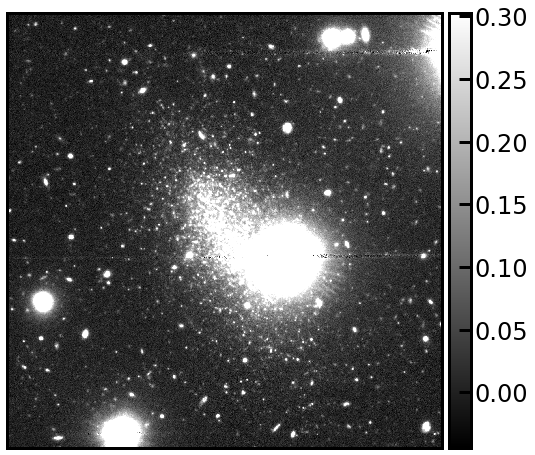

In [19]:
plt.rcParams.update({'figure.figsize' : (9, 8)})

# Use lsst.afw.display with the matplotlib backend to display the image
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(imgCutout.exposure.image)
plt.xticks([])
plt.yticks([])
# plt.savefig('kkr25_image.png') # Uncomment if you want to save the image.
plt.show()

<Figure size 648x576 with 0 Axes>

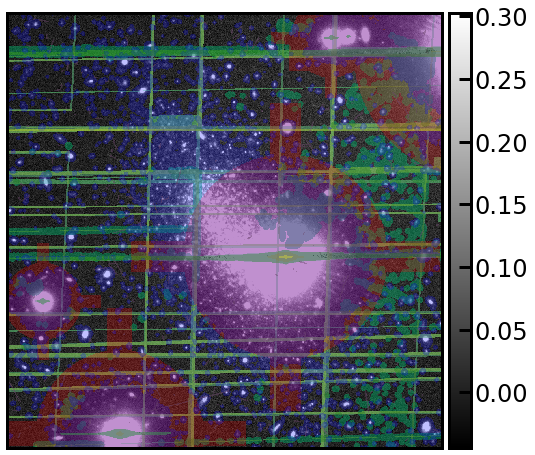

In [20]:
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(imgCutout.exposure.maskedImage)
plt.xticks([])
plt.yticks([])
plt.show()

In [21]:
# The MaskedImage is overplotting the values of the mask plane. 
# Extract the mapping between mask color and mask bit directly from the mask object:

for maskName, maskBit in imgCutout.exposure.mask.getMaskPlaneDict().items():
    print('{}: {}'.format(afw_display.getMaskPlaneColor(maskName),maskName))


red: BAD
None: BRIGHT_OBJECT
None: CLIPPED
magenta: CR
None: CROSSTALK
blue: DETECTED
cyan: DETECTED_NEGATIVE
yellow: EDGE
None: INEXACT_PSF
green: INTRP
None: NOT_DEBLENDED
orange: NO_DATA
None: REJECTED
green: SAT
None: SENSOR_EDGE
yellow: SUSPECT
None: UNMASKEDNAN


In [56]:
imgCutout.exposure.mask.getMaskPlaneDict

<bound method PyCapsule.getMaskPlaneDict of lsst.afw.image.image.MaskX=[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0  12  12 ...   0   0   0]
 ...
 [  0   0   0 ... 544 544 544]
 [  0   0   0 ... 544 544 544]
 [  0   0   0 ... 544 544 544]], bbox=(minimum=(5625, 19120), maximum=(6696, 20191)), maskPlaneDict={'BAD': 0, 'BRIGHT_OBJECT': 9, 'CLIPPED': 10, 'CR': 3, 'CROSSTALK': 11, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INEXACT_PSF': 12, 'INTRP': 2, 'NOT_DEBLENDED': 13, 'NO_DATA': 8, 'OTHERDET': 18, 'REJECTED': 14, 'SAT': 1, 'SENSOR_EDGE': 15, 'SUSPECT': 7, 'THISDET': 17, 'UNMASKEDNAN': 16}>

In [22]:
dr14_i = dataref14.copy()
dr14_i['filter'] = 'HSC-I'
dr14_r = dataref14.copy()
dr14_r['filter'] = 'HSC-R'
dr14_g = dataref14.copy()
dr14_g['filter'] = 'HSC-G'
cat_g, refcat_g, mags_g = cutoutCatalog(raDec, size_arcmin, dr14_g)
cat_r, refcat_r, mags_r = cutoutCatalog(raDec, size_arcmin, dr14_r)
cat_i, refcat_i, mags_i = cutoutCatalog(raDec, size_arcmin, dr14_i)

Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
patch: 1
length of tmp_src, tmp_ref, tmp_mags:  30285 30285 30285
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
patch:  2
length of tmp_src, tmp_ref, tmp_mags:  61007 61007 61007
Making deep copies
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch

In [23]:
is_primary = (refcat_g['detect_isPrimary'] == True) & (refcat_r['detect_isPrimary'] == True) &\
             (refcat_i['detect_isPrimary'] == True) 
is_finite = (np.isfinite(cat_g.getPsfInstFlux())) & (np.isfinite(cat_r.getPsfInstFlux())) & (np.isfinite(cat_i.getPsfInstFlux()))
ptsource = (cat_g['base_ClassificationExtendedness_flag'] == False) & (cat_r['base_ClassificationExtendedness_flag'] == False) & (cat_i['base_ClassificationExtendedness_flag'] == False)


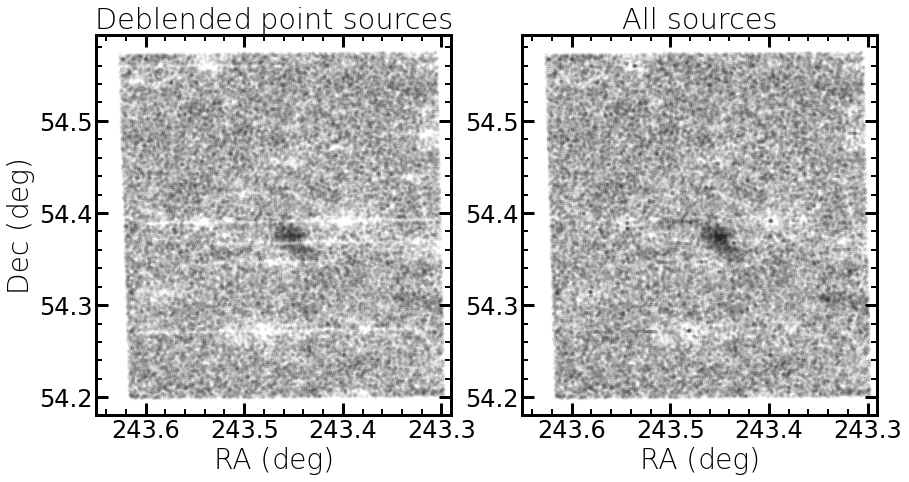

In [24]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.subplot(121)
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource]),np.rad2deg(cat_g['coord_dec'][is_primary & ptsource]),'k.',alpha=0.05)
plt.xlim(243.65,243.29)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.title('Deblended point sources')

plt.subplot(122)
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary]),np.rad2deg(cat_g['coord_dec'][is_primary]),'k.',alpha=0.05)
plt.xlim(243.65,243.29)
plt.title('All sources')
plt.xlabel('RA (deg)')
plt.minorticks_on()

In [25]:
# Read in the isochrone file:
iso = ascii.read('/project/jcarlin/isochrones/parsec12_panstarrs1/0_000500.dat',header_start = 13)

dist = 1.7e6 # in pc # Roughly the distance to KKR 25 (see the NED link above)
ebv = 0.008 # (E(B-V) = 0.008 according to Makarov+2012) -- You could also look this up using the central coordinates.
dmod = 5.0*np.log10(dist) - 5.0 # convert distance to distance modulus

# Raw PS1-band isochrone magnitudes
g_iso_ps1 = iso['gP1']
r_iso_ps1 = iso['rP1']
i_iso_ps1 = iso['iP1']

# Extinction coefficients from Schlafly+2011:
A_g = 3.172 * ebv
A_r = 2.271 * ebv
A_i = 1.682 * ebv

# NOTE: we are *adding* extinction to the isochrone, instead of looking up the values for all stars. We'll work with
#   un-dereddened magnitudes throughout.
g_iso = g_iso_ps1 + dmod + A_g
r_iso = r_iso_ps1 + dmod + A_r
i_iso = i_iso_ps1 + dmod + A_i

In [26]:
# Select a smaller region around KKR 25:
coord_g = SkyCoord(cat_g['coord_ra']*u.radian, cat_g['coord_dec']*u.radian, frame='icrs')
### Notice in the line above that coordinates in the catalog are in radians by default.

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_kkr25 = coord_g.separation(kkr25_pos)

# Select within some small radius:
sel_rad = 2.5 # radius in arcminutes
sel_cen = (sep_kkr25.arcmin < sel_rad)

In [27]:
# difference in mags (PSF - cmodel)
magdiff_i = mags_i['psfmag'][:,0]-mags_i['modelmag'][:,0]
starsel_i = (np.abs(magdiff_i) < 0.05)

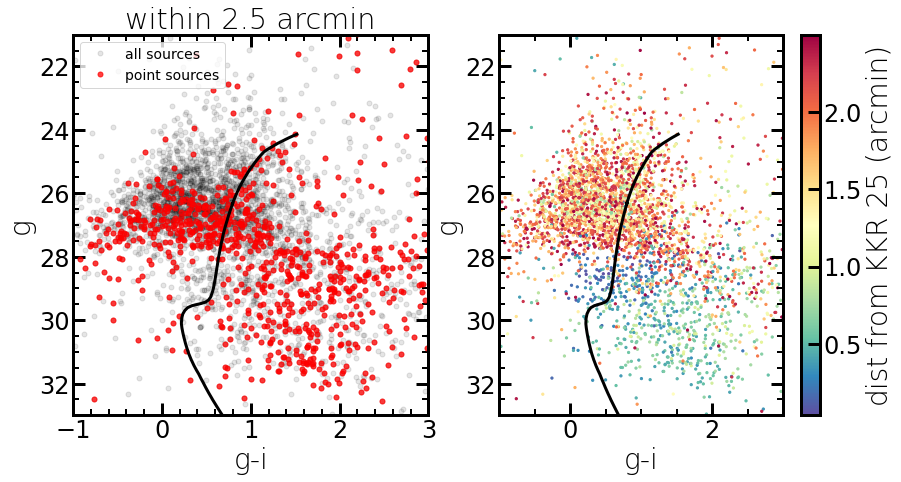

In [28]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.figure()

# The following selects only up to the RGB tip (i.e., no post-RGB, AGB, etc.) from the isochrone, for clarity
okstage = (iso['stage'] <= 3)

plt.subplot(121)
plt.plot(mags_g['psfmag'][is_primary & sel_cen][:,0]-mags_i['psfmag'][is_primary & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & sel_cen][:,0], 'ko', ms=5, alpha=0.1, label='all sources')
plt.plot(mags_g['psfmag'][is_primary & starsel_i & sel_cen][:,0]-mags_i['psfmag'][is_primary & starsel_i & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75, label='point sources')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k', label='__no label__')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.legend()
plt.xlim(-1,3)
plt.ylim(33,21)
plt.title('within 2.5 arcmin')
plt.minorticks_on()

plt.subplot(122)
plt.scatter(mags_g['psfmag'][is_primary & sel_cen][:,0]-mags_i['psfmag'][is_primary & sel_cen][:,0],\
            mags_g['psfmag'][is_primary & sel_cen][:,0], c=sep_kkr25[is_primary & sel_cen].arcmin, cmap='Spectral_r', s=5)
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.xlim(-1,3)
plt.ylim(33,21)
plt.colorbar(label='dist from KKR 25 (arcmin)')
plt.minorticks_on()
plt.show()
#plt.savefig('cmds_kkr25_noisereplace_on.png')

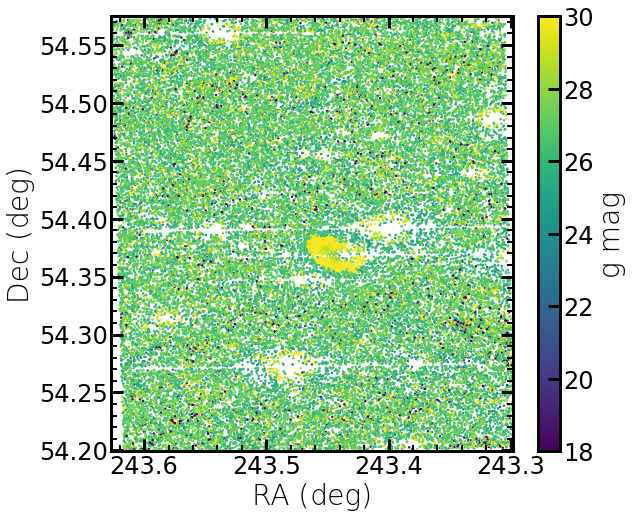

In [29]:
plt.rcParams.update({'figure.figsize' : (9, 8)})

gmags0 = mags_g['psfmag']
gmags0[np.isnan(gmags0)] = 0.0
plt.scatter(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource]),\
            np.rad2deg(cat_g['coord_dec'][is_primary & ptsource]),\
            c=gmags0[is_primary & ptsource][:,0],s=2,vmax=30,vmin=18)
# NOTE: in the above line, gmags0 must be subscripted to select only the magnitude column. gmags0 contains both the
#       magnitudes and their errors, so to get mags only, use gmags0[:0] (for errors, use gmags0[:1])

plt.xlim(np.max(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])),\
         np.min(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])))
plt.ylim(np.min(np.rad2deg(cat_g['coord_dec'][is_primary & ptsource])),\
         np.max(np.rad2deg(cat_g['coord_dec'][is_primary & ptsource])))
plt.colorbar(label='g mag')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()

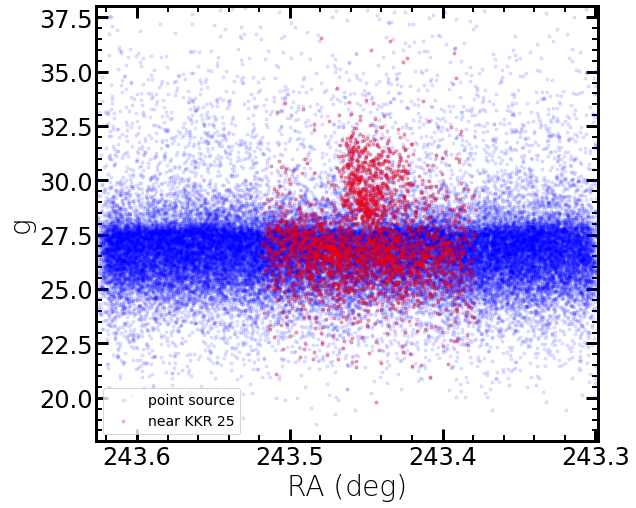

In [30]:
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource]),\
         gmags0[is_primary & ptsource][:,0],'b.',alpha=0.1, label='point source')
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource & sel_cen]),\
         gmags0[is_primary & ptsource & sel_cen][:,0],'r.',alpha=0.25, label='near KKR 25')
plt.ylim(18,38)
plt.xlim(np.max(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])),\
         np.min(np.rad2deg(cat_g['coord_ra'][is_primary & ptsource])))
plt.legend()
plt.xlabel('RA (deg)')
plt.ylabel('g')
plt.minorticks_on()

In [31]:
## Source catalog:
cat14 = butler.get('deepCoadd_forced_src', dataId=dr14_g)

# Reference object:
ref14 = butler.get('deepCoadd_ref', dataId=dr14_g)

# Calibrated exposure:
calexp14 = butler.get('deepCoadd_calexp', dataId=dr14_g)
# We are going to manipulate calexp14, so make a clone of the original:
calexp14_orig = calexp14.clone()

In [32]:
# extract the footprints of all detected sources into a dict:
fp_dict_g = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint()) for measRecord in ref14}

In [33]:
# Instantiate the NoiseReplacer and feed it the calexp image and the footprints:
nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, calexp14, fp_dict_g)

<Figure size 648x576 with 0 Axes>

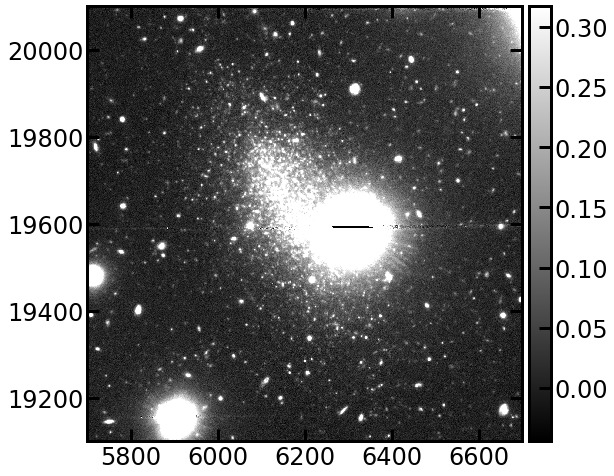

In [34]:
# Display the original image:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('linear', 'zscale')
afw_display.mtv(calexp14_orig.getImage()[5700:6700,19100:20100])

<Figure size 648x576 with 0 Axes>

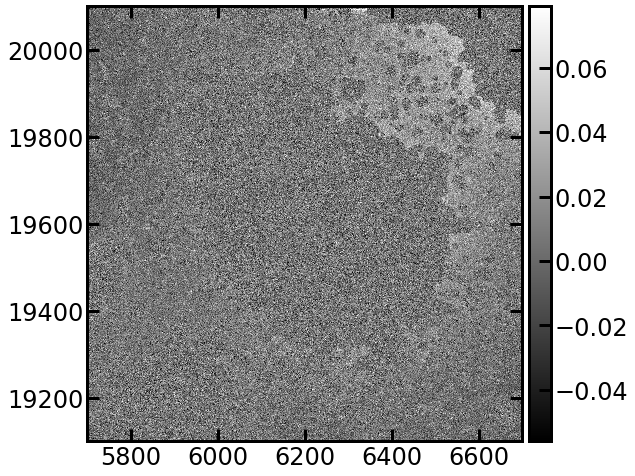

In [35]:
# Display the image with the source footprints replaced by noise:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('linear', 'zscale')
afw_display.mtv(calexp14.getImage()[5700:6700,19100:20100])

In [36]:
# Extract a small cutout image, offset slightly from the center of KKR 25, for efficiency:
cutout_pos = SkyCoord(kkr25_pos.ra+(0.5*u.arcmin), kkr25_pos.dec+(0.5*u.arcmin), frame='icrs') # KKR25
raDec_cutout = geom.SpherePoint(cutout_pos.ra.value, cutout_pos.dec.value, geom.degrees)
# Extract the cutout image:
cutout_size = 0.4 # in arcmin
gcutout = cutoutImage(raDec_cutout, cutout_size, dr14_g)
icutout = cutoutImage(raDec_cutout, cutout_size, dr14_i)
gcat, grefcat, gcutout_mags = cutoutCatalog(raDec_cutout, cutout_size, dr14_g)
icat, irefcat, icutout_mags = cutoutCatalog(raDec_cutout, cutout_size, dr14_i)

npixels:  143
cutoutSize:  (143, 143)
(6059.5, 19836)
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19764), dimensions=Extent2I(144, 144)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19900), dimensions=Extent2I(144, 8)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G'}


<ipython-input-16-4f7935e757dc>:56: FutureWarning: Call to deprecated method getFilter. (Replaced by getFilterLabel. Will be removed after v22.) -- Deprecated since version v22.0.
  coaddFilter = coaddPatch.getFilter()
<ipython-input-16-4f7935e757dc>:61: FutureWarning: Call to deprecated method setFilter. (Replaced by setFilterLabel. Will be removed after v22.) -- Deprecated since version v22.0.
  coaddExposure.setFilter(coaddFilter)


npixels:  143
cutoutSize:  (143, 143)
(6059.5, 19836)
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19764), dimensions=Extent2I(144, 144)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-I'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5987, 19900), dimensions=Extent2I(144, 8)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-I'}


<ipython-input-16-4f7935e757dc>:56: FutureWarning: Call to deprecated method getFilter. (Replaced by getFilterLabel. Will be removed after v22.) -- Deprecated since version v22.0.
  coaddFilter = coaddPatch.getFilter()
<ipython-input-16-4f7935e757dc>:61: FutureWarning: Call to deprecated method setFilter. (Replaced by setFilterLabel. Will be removed after v22.) -- Deprecated since version v22.0.
  coaddExposure.setFilter(coaddFilter)


Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
patch: 1
length of tmp_src, tmp_ref, tmp_mags:  30285 30285 30285
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
patch:  2
length of tmp_src, tmp_ref, tmp_mags:  61007 61007 61007
Making deep copies
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch

In [37]:
# data quality cuts as we did before
is_primary_cutout = (grefcat['detect_isPrimary'] == True) &\
                    (irefcat['detect_isPrimary'] == True) 
is_finite_cutout = (np.isfinite(gcat.getPsfInstFlux())) & (np.isfinite(icat.getPsfInstFlux()))
magcut_cutout = (gcutout_mags['psfmag'][:,0] < 28.0)
ptsource_cutout = (gcat['base_ClassificationExtendedness_flag'] == False) &\
                  (icat['base_ClassificationExtendedness_flag'] == False)

In [38]:
# Cut down the list of footprints from the entire calexp to only those in the small subregion of interest:
# X: 5970-6130, Y: 19775-19905
xmin = 5970
xmax = 6130
ymin = 19775
ymax = 19905
keep14 = (ref14.getX() < xmax) & (ref14.getX() > xmin) & (ref14.getY() < ymax) & (ref14.getY() > ymin)
ref14keep = ref14[keep14]
fp_dict_g14 = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint()) for measRecord in ref14keep}
srcids14 = ref14keep['id']

In [39]:
# Make another clone of the calexp image, in which we will:
# (a) Replace pixels in all source footprints with noise, then
# (b) Add a single source footprint's back into the image.

c14 = calexp14_orig.clone()

# Instantiate the NoiseReplacer and feed it the calexp image and the footprints:
nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, c14, fp_dict_g14)

# The following line simply selects an index number for which source (from srcids14) to visualize.
# (Change the integer to visualize a different source.)
ind = 17 # 53, 55, 56 are huge!, 21 is crazy huge!
noiseReplacer.insertSource(srcids14[ind])
print('(X,Y): ', ref14keep[ind].getX(), ref14keep[ind].getY())

(X,Y):  5990.871406813854 19843.57847613764


In [40]:
# Extract the image array for the selected footprint:
fp = fp_dict_g14[srcids14[ind]][1].getSpans().unflatten(fp_dict_g14[srcids14[ind]][1].getImageArray())
# Extract the bounding box for the footprint:
fp_bbox = fp_dict_g14[srcids14[ind]][1].getBBox()

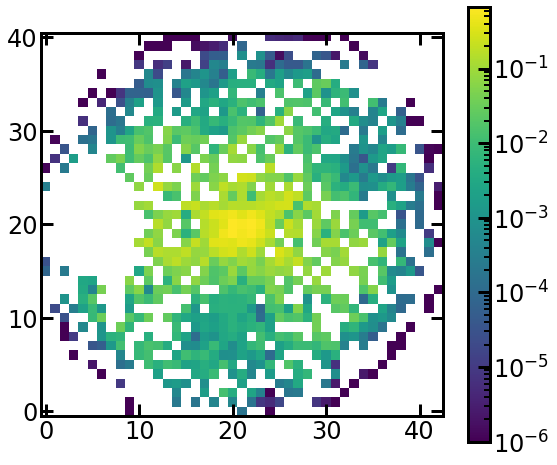

In [41]:
from matplotlib.colors import LogNorm
plt.imshow(fp,
           cmap='viridis', origin='lower', norm=LogNorm(vmin=1e-6, vmax=fp.max()))
plt.colorbar()

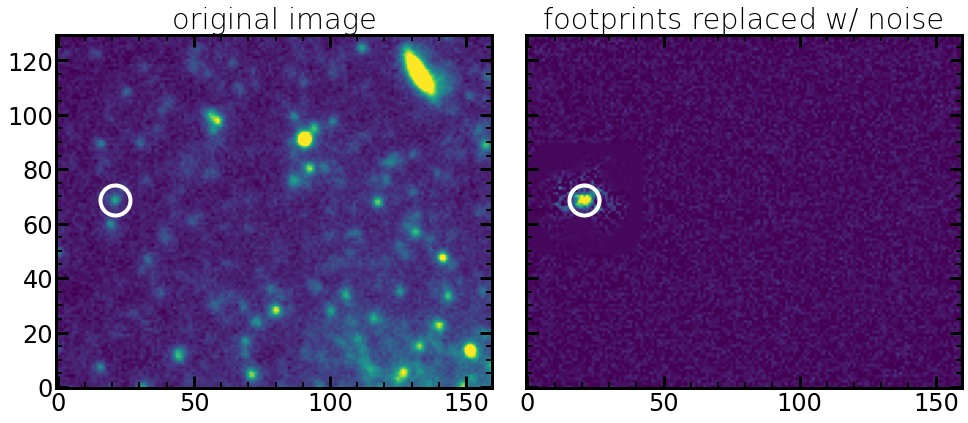

In [42]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

f, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

axflat = ax.flatten()
ax1 = axflat[0]
ax2 = axflat[1]
data = calexp14_orig.getMaskedImage()[xmin:xmax,ymin:ymax].getImage().array
ax1.minorticks_on()
ax1.imshow(data, origin='lower',vmin=-0.01, vmax=0.5)
ax1.plot(ref14keep[ind].getX()-xmin, ref14keep[ind].getY()-ymin, 'o', ms=30, color='white', fillstyle='none', markeredgewidth=4)
ax1.set_title('original image')

data = c14.getMaskedImage()[xmin:xmax,ymin:ymax].getImage().array
ax2.imshow(data, origin='lower',vmin=-0.01, vmax=0.5)
ax2.plot(ref14keep[ind].getX()-xmin, ref14keep[ind].getY()-ymin, 'o', ms=30, color='white', fillstyle='none', markeredgewidth=4)
ax2.minorticks_on()
ax2.set_title('footprints replaced w/ noise')
plt.tight_layout()

In [43]:
# Make another clone of the calexp image, in which we will:
# (a) Replace pixels in all source footprints with noise, then
# (b) Add a single source footprint's back into the image.

c14 = calexp14_orig.clone()

# Instantiate the NoiseReplacer and feed it the calexp image and the footprints:
noiseReplacer = NoiseReplacer(nr_config, c14, fp_dict_g14)

# The following line simply selects an index number for which source (from srcids14) to visualize.
# (Change the integer to visualize a different source.)
ind_large = 56
noiseReplacer.insertSource(srcids14[ind_large])
print('(X,Y): ', ref14keep[ind_large].getX(), ref14keep[ind_large].getY())

(X,Y):  6079.256735240704 19830.9733978407


In [44]:
# Extract the image array for the selected footprint:
fp_large = fp_dict_g14[srcids14[ind_large]][1].getSpans().unflatten(fp_dict_g14[srcids14[ind_large]][1].getImageArray())
# Extract the bounding box for the footprint:
fp_bbox_large = fp_dict_g14[srcids14[ind_large]][1].getBBox()

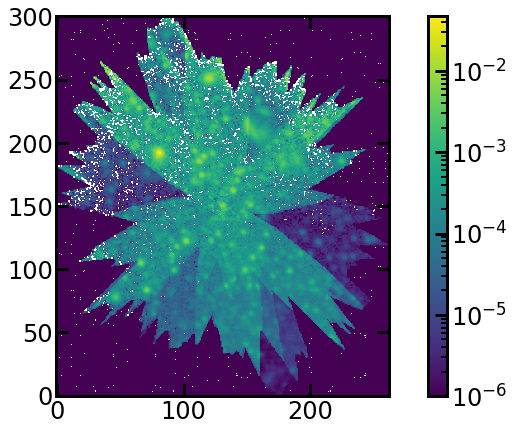

In [45]:
plt.imshow(fp_large,
           cmap='viridis', origin='lower', norm=LogNorm(vmin=1e-6, vmax=fp_large.max()))
plt.colorbar()
plt.show()

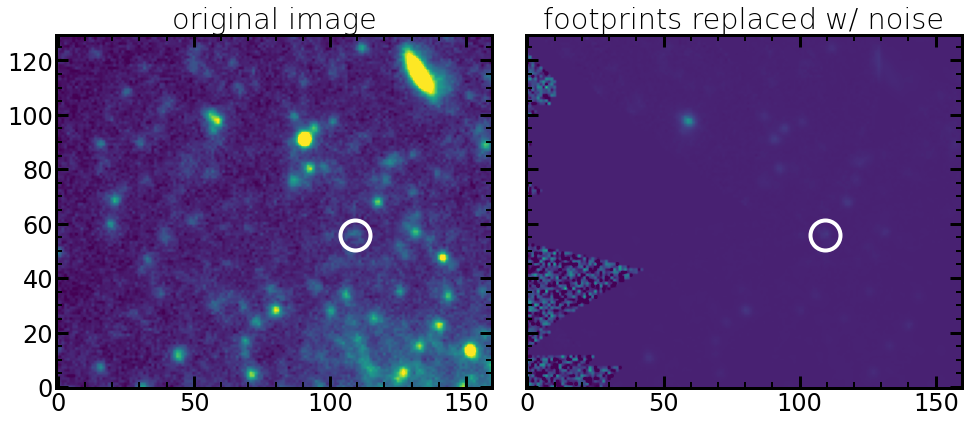

In [46]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

f, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

axflat = ax.flatten()
ax1 = axflat[0]
ax2 = axflat[1]
data = calexp14_orig.getMaskedImage()[xmin:xmax,ymin:ymax].getImage().array
ax1.minorticks_on()
ax1.imshow(data, origin='lower',vmin=-0.01, vmax=0.5)
ax1.plot(ref14keep[ind_large].getX()-xmin, ref14keep[ind_large].getY()-ymin, 'o', ms=30, color='white', fillstyle='none', markeredgewidth=4)
ax1.set_title('original image')

data = c14.getMaskedImage()[xmin:xmax,ymin:ymax].getImage().array
ax2.imshow(data, origin='lower',vmin=-0.01, vmax=0.1)
ax2.plot(ref14keep[ind_large].getX()-xmin, ref14keep[ind_large].getY()-ymin, 'o', ms=30, color='white', fillstyle='none', markeredgewidth=4)
ax2.minorticks_on()
ax2.set_title('footprints replaced w/ noise')
plt.tight_layout()

In [47]:
# Check the area of the footprints we have selected:
srctmp = ref14keep[ind]
fprtmp = srctmp.getFootprint()
srctmp_large = ref14keep[ind_large]
fprtmp_large = srctmp_large.getFootprint()
print(fprtmp.getArea(),' pixels^2, ',fprtmp_large.getArea(),' pixels^2')

1582  pixels^2,  46125  pixels^2


In [48]:
butler = dafPersist.Butler('/project/jcarlin/kkr25/rerun/noise_replace_offPDR2')

In [49]:
size_arcmin = 3.0

# Create a SpherePoint object at the center of KKR 25:
raDec = geom.SpherePoint(kkr25_pos.ra.value, kkr25_pos.dec.value, geom.degrees)

# Tract/patch where KKR 25's center appears
tract = 17130
patch = '1,4'
dr14_g = {'tract':tract, 'patch':patch, 'filter':'HSC-G'}
dr14_r = {'tract':tract, 'patch':patch, 'filter':'HSC-R'}
dr14_i = {'tract':tract, 'patch':patch, 'filter':'HSC-I'}

cat_g, refcat_g, mags_g = cutoutCatalog(raDec, size_arcmin, dr14_g)
cat_r, refcat_r, mags_r = cutoutCatalog(raDec, size_arcmin, dr14_r)
cat_i, refcat_i, mags_i = cutoutCatalog(raDec, size_arcmin, dr14_i)

Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
patch: 1
length of tmp_src, tmp_ref, tmp_mags:  25597 25597 25597
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
patch:  2
length of tmp_src, tmp_ref, tmp_mags:  53655 53655 53655
Making deep copies
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch

In [50]:
is_primary = (refcat_g['detect_isPrimary'] == True) & (refcat_r['detect_isPrimary'] == True) &\
             (refcat_i['detect_isPrimary'] == True) 
is_finite = (np.isfinite(cat_g.getPsfInstFlux())) & (np.isfinite(cat_r.getPsfInstFlux())) & (np.isfinite(cat_i.getPsfInstFlux()))
deblended = (cat_g['deblend_nChild'] == 0) & (cat_r['deblend_nChild'] == 0) & (cat_i['deblend_nChild'] == 0)
ptsource = (cat_g['base_ClassificationExtendedness_flag'] == False) & (cat_r['base_ClassificationExtendedness_flag'] == False) & (cat_i['base_ClassificationExtendedness_flag'] == False)

In [51]:
# Select a smaller region around KKR 25:
coord_g = SkyCoord(cat_g['coord_ra']*u.radian, cat_g['coord_dec']*u.radian, frame='icrs')

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_kkr25 = coord_g.separation(kkr25_pos)

# Select within some small radius:
sel_rad = 2.5
sel_cen = (sep_kkr25.arcmin < sel_rad)

In [52]:
# difference in mags (PSF - cmodel)
magdiff_i = mags_i['psfmag'][:,0]-mags_i['modelmag'][:,0]
starsel_i = (np.abs(magdiff_i) < 0.05)

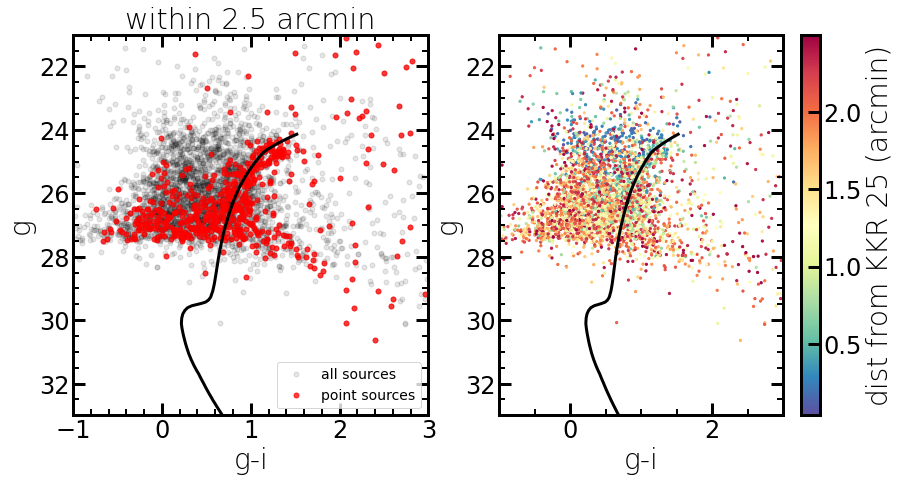

In [53]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.figure()

okstage = (iso['stage'] <= 3)

plt.subplot(121)
plt.plot(mags_g['psfmag'][is_primary & deblended & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & deblended & sel_cen][:,0], 'ko', ms=5, alpha=0.1, label='all sources')
plt.plot(mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75, label='point sources')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k', label='__no label__')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.legend()
plt.xlim(-1,3)
plt.ylim(33,21)
plt.title('within 2.5 arcmin')
plt.minorticks_on()

plt.subplot(122)
plt.scatter(mags_g['psfmag'][is_primary & sel_cen][:,0]-mags_i['psfmag'][is_primary & sel_cen][:,0],\
            mags_g['psfmag'][is_primary & sel_cen][:,0], c=sep_kkr25[is_primary & sel_cen].arcmin, cmap='Spectral_r', s=5)
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.xlim(-1,3)
plt.ylim(33,21)
plt.colorbar(label='dist from KKR 25 (arcmin)')
plt.minorticks_on()
plt.show()